# Bases de datos empleadas

Se han fusionado diferentes bases de datos de secuencias peptídicas con diferentes actividades, ya sean con implicaciones antimicrobianas o no, y de diferente origen:

- **dbAMP 2.0**: Un sistema integrado para identificar péptidos antimicrobianos (AMPs) con sus tipos funcionales basado en datos de transcriptoma y proteoma de alto rendimiento.

https://awi.cuhk.edu.cn/dbAMP/index.php


- **FermFooDb**: Una base de datos de péptidos derivados de alimentos fermentados contiene 2325 entradas de péptidos únicos de los alimentos fermentados. La matriz alimentaria varía desde leche de diferentes animales como vaca, oveja, cabra y camello, proteínas de carne, proteínas de leche de soja, yogur, vino de arroz y queso.

https://webs.iiitd.edu.in/raghava/fermfoodb/

- **APD3**: Esta base de datos original de péptidos antimicrobianos está curada manualmente según un conjunto de criterios de recopilación de datos.

https://aps.unmc.edu/

- **DRAMP Database**: Repositorio de Datos de Péptidos Antimicrobianos es una base de datos de acceso abierto y curada manualmente que alberga diversas anotaciones de AMPs incluyendo secuencias, estructuras, actividades, información fisicoquímica, patentes, clínica y referencias. El conjunto de datos clínicos también incluye información sobre la fase del ensayo clínico, aplicaciones terapéuticas, compañía y fuentes de literatura de AMP preclínicas o clínicas.

http://dramp.cpu-bioinfor.org/

In [1]:
# Carga de los csv creados de cada base de datos

import pandas as pd
import os
from Bio import SeqIO

# Define el directorio donde están los archivos CSV
directorio = 'sub_files_bds/'

# Lista para almacenar los dataframes
dataframes = []

# Recorre todos los archivos en el directorio
for archivo in os.listdir(directorio):
    if archivo.endswith('.csv'): 
        ruta_completa = os.path.join(directorio, archivo)
        df = pd.read_csv(ruta_completa)
        dataframes.append(df)

# Concatena todos los dataframes en uno solo
df = pd.concat(dataframes, ignore_index=True, sort=False)


In [2]:
df

,ID_Peptide,PubMed_ID,Sequence,Activity
0,FMDB1,18521593,DP,Ace-inhibitory
1,FMDB1000,18627167,PVAPLQRSGPE,Ace-inhibitory
2,FMDB1001,18627167,PRSGNVGESGL,Ace-inhibitory
3,FMDB1002,18627167,VAPSRPTPR,Ace-inhibitory
4,FMDB1003,18627167,DIIIPD,Ace-inhibitory
...,...,...,...,...
46496,DRAMP18146,NaN,DCLGQWASCEPKNSKCCPNYACTWKYPWCRYRA,Insecticidal
46497,DRAMP18148,NaN,ATCAGQDQTCKVTCDCCGERGECVCGGPCICRQGNFLIAWYKLASCKK,Insecticidal
46498,DRAMP18149,NaN,DCGHLHDPCPNDRPGHRTCCIGLQCRYGKCLVRV,Insecticidal
46499,DRAMP01272,NaN,ATCAGQDQPCKETCDCCGERGECVCGGPCICRQGYFWIAWYKLANCKK,Insecticidal


In [3]:
# Crear la nueva columna 'db_source' extrayendo las letras de 'ID_Peptide'
df['db_source'] = df['ID_Peptide'].str.extract('([A-Za-z]+)', expand=False)

# Imprimir los valores únicos
print(df['db_source'].unique())

['FMDB' 'dbAMP' 'DRAMP']


De la fusión de las diferentes bases de datos obtenemos una base de datos con **46501 filas** (sequencias de aminoácidos) y **4 cuolumnas** (ID_Peptide, PumMed_ID, Sequence y Activity).

# Procesamiento de la base de datos creada

A continuación se procederá a añadir más información a la base de datos, así como prepara las secuencias para el cálculo de descriptores fisicoquímicos y Machine Learning.

## Añadir identificadores de diferentes bases de datos

Debido a que no todas las secuencias están identificadas en todas las bases de datos, con el objetivo de crear una base de datos más completa se añadirán diferentes identificadores, siendo estos los de UniProt y APD3.

### dbAMP

De esta base de datos se pueden recuperar los identificadores de UniProt, así como el Target específico de algunos péptidos.

In [4]:
import pandas as pd

# Cargar el archivo Excel con las columnas necesarias
df_excel = pd.read_excel('sub_files_bds/dbAMPv2.0/dbAMP_pepinfo_20210922.xls')

# Combinar usando el ID de Peptide
df = pd.merge(df, df_excel[['dbAMP_ID', 'Uniprot', 'Targets']], left_on='ID_Peptide', right_on='dbAMP_ID', how='left')

# Crear la columna Uniprot_ID y llenarla con los valores de Uniprot
df['Uniprot_ID'] = df.get('Uniprot_ID', pd.Series([pd.NA]*len(df)))  # Crea la columna con valores NA si no existe
df['Uniprot_ID'] = df['Uniprot_ID'].fillna(df['Uniprot'])  # Llena los valores NA con la columna Uniprot

df.drop(columns=['Uniprot', 'dbAMP_ID'], inplace=True)  

# Insertar la columna UniProt_ID en la posición deseada
df.insert(2, 'UniProt_ID', df.pop('Uniprot_ID'))

### APD3

De esta base de datos se pueden recuperar los identificadores propios, en APD_ID.

In [5]:
# Cargar el archivo FASTA y crear el diccionario de mapeo
fasta_file = 'sub_files_bds/APD_sequence_release_09142020.fasta' 
id_map = {}
for record in SeqIO.parse(fasta_file, 'fasta'):
    description = record.description
    peptide_id = description.split('|')[0].strip() 
    sequence = str(record.seq)
    id_map[sequence] = peptide_id

# Añadir la columna de ID mapeando las secuencias
df['APD_ID'] = df['Sequence'].map(id_map)

df.insert(3, 'APD3_ID', df.pop('APD_ID'))

### DRAMP

De esta base de datos se recuperaron identificadores UniProt, así como Targets de los diferentes péptidos.

In [6]:
# Cargar el archivo .xlsx 
ruta_del_archivo = 'sub_files_bds/dramp.xlsx'
df_dramp = pd.read_excel(ruta_del_archivo, engine='openpyxl')

# Realiza un merge entre df y df_dramp basándote en la columna 'Sequence'
merged_df = pd.merge(df, df_dramp[['Sequence', 'Target_Organism']], on='Sequence', how='left')

# Actualiza la columna 'Target' en df donde las condiciones son cumplidas
df['Targets'] = merged_df.apply(
    lambda row: row['Target_Organism'] if pd.notna(row['Target_Organism']) and row['Target_Organism'] != 'No MICs found on DRAMP database' else row['Targets'],
    axis=1
)

A continuación se calcularán cuantas secuencias de aminoácidos tienen los diferentes identificadores.

In [7]:
# Columnas para evaluar
columns = ['APD3_ID', 'UniProt_ID', 'PubMed_ID']

# Diccionario para guardar los conteos
data = {'NaN': {}, 'Non-NaN': {}}

# Contar NaN y no-NaN en cada columna especificada
for column in columns:
    data['NaN'][column] = df[column].isna().sum()
    data['Non-NaN'][column] = df[column].notna().sum()

# Crear DataFrame a partir del diccionario
summary_df = pd.DataFrame(data)

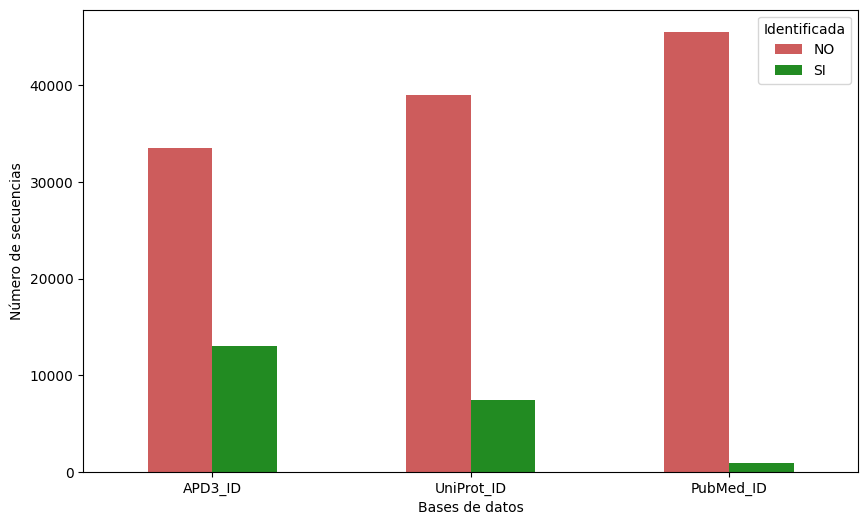

In [8]:
import matplotlib.pyplot as plt

summary_df = summary_df.fillna('NO')
summary_df = summary_df.replace({x: 'SI' for x in summary_df.columns if x != 'NO'})

# Gráfico de barras
ax = summary_df.plot(kind='bar', color=['indianred', 'forestgreen'], figsize=(10, 6))

# Añadir etiquetas y título
plt.title('')
plt.xlabel('Bases de datos')
plt.ylabel('Número de secuencias')
plt.xticks(rotation=0)  # Ajustar la rotación de las etiquetas del eje x
plt.legend(title='Identificada', labels=['NO', 'SI'])

# Guardar la figura
plt.savefig("graph_plots/seq_id_bds.png", bbox_inches='tight', dpi=300)
plt.show()

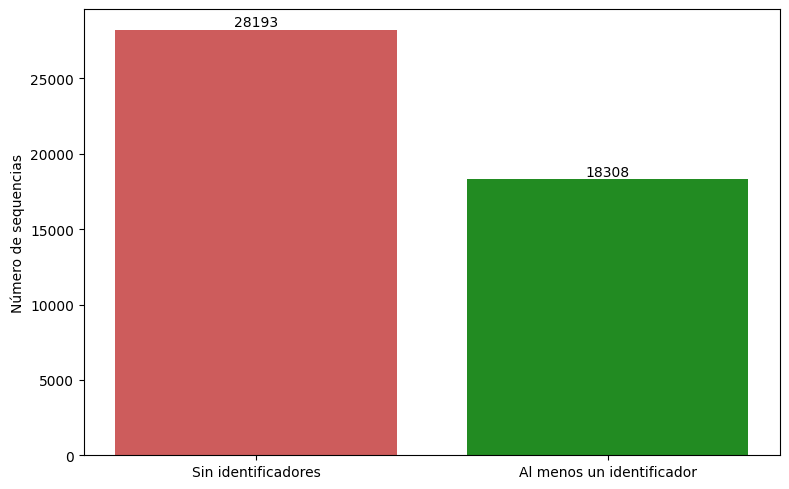

In [9]:
# Calcular filas con todos los valores como NaN
all_nan_count = df[columns].isna().all(axis=1).sum()

# Calcular filas con al menos un identificador no-NaN
some_not_nan_count = df[columns].notna().any(axis=1).sum()

# Datos para el gráfico
counts = [all_nan_count, some_not_nan_count]
labels = ['Sin identificadores', 'Al menos un identificador']

# Crear gráfico de barras
plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color=['indianred', 'forestgreen'])
plt.title('')
plt.ylabel('Número de sequencias')
for i, v in enumerate(counts):
    plt.text(i, v + 50, str(v), ha='center', va='bottom')

plt.tight_layout()

# Guardar la figura antes de mostrarla
plt.savefig("graph_plots/seq_id_no_id.png", bbox_inches='tight', dpi=300)
plt.show()

## Depuración de la base de datos

### Clusterización de las actividades

Hay péptidos que tienen más de una actividad, y muchas de ellas son antagonistas a la hora de categorizarlas por AMP y no AMP, por lo que cada fila será una sola actividad para una secuencia.

In [10]:
# Dividir los valores de la columna 'Activity' por ';'
df['Activity'] = df['Activity'].str.split(';')

# Usar explode para expandir las listas en filas
df_f = df.explode('Activity')

# Ahora imprimir los valores únicos de la columna 'Activity' después de la separación
print(df_f['Activity'].unique())

['Ace-inhibitory' 'Antioxidant' 'Anti-hypertensive' 'Immunomodulatory'
 'Cytomodulatory' 'Anti-microbial' 'Antibacterial'
 'Antibacterial against Enterococcus faecium' 'Bacillus megaterium'
 'Escherichia coli' 'Listeria innocua' 'Salmonella spp.'
 'Yersinia enterocolitica' '' 'Staphylococcus aureus'
 'Cholestrol-lowering' 'Opioid' 'Anti-microbial against S.aureus'
 'Antithrombotic' 'Anti-microbial against E. coli ATCC 8099'
 'Anti-microbial against B. megaterium F6 as indicator'
 'Anti-microbial against Enterobacter sakazakii ATCC 12868'
 'Escherichia coli DPC5063'
 'Anti-microbial against Cronobacter sakazakii DPC 6440' 'LOX inhibitor'
 'Mitogene' 'Opioid agonist' 'Opioid antagonist'
 'Casoxin C (Opioid antagonist)' 'CasoxinA (Opioid antagonist)'
 'Antiangiogenesis' 'Antidiabetic' 'Antifungal' 'Antihypertensive'
 'Antiinflammatory' 'AntiNematode' 'Antineurotensive' 'Antinociceptive'
 'Antiparasitic' 'Antiprotozoal' 'Antitumour' 'Antiviral' 'CellCancer'
 'CellPenetrating' 'Chemotactic'

In [11]:
# Cambiar el valor específico en la columna 'Activity' para detallar más el tarjet
df_f['Activity'] = df_f['Activity'].replace('Casoxin C (Opioid antagonist)', 'Opioid')
df_f['Activity'] = df_f['Activity'].replace('CasoxinA (Opioid antagonist)', 'Opioid')
df_f['Activity'] = df_f['Activity'].replace('Escherichia coli DPC5063', 'Antibacterial against Escherichia coli DPC5063')
df_f['Activity'] = df_f['Activity'].replace('Bacillus megaterium', 'Antibacterial against Bacillus megaterium')
df_f['Activity'] = df_f['Activity'].replace('Escherichia coli', 'Antibacterial against Escherichia coli')
df_f['Activity'] = df_f['Activity'].replace('Listeria innocua', 'Antibacterial against Listeria innocua')
df_f['Activity'] = df_f['Activity'].replace('Salmonella spp.', 'Antibacterial against Salmonella spp.')
df_f['Activity'] = df_f['Activity'].replace('Yersinia enterocolitica', 'Antibacterial against Yersinia enterocolitica')
df_f['Activity'] = df_f['Activity'].replace('Staphylococcus aureus', 'Antibacterial against Staphylococcus aureus')
df_f['Activity'] = df_f['Activity'].replace('Anti-hypertensive', 'Antihypertensive')
df_f['Activity'] = df_f['Activity'].replace('Anti-microbial', 'Antimicrobial')
df_f['Activity'] = df_f['Activity'].replace('Anti-microbial against S.aureus', 'Antibacterial against Staphylococcus aureus')
df_f['Activity'] = df_f['Activity'].replace('Anti-microbial against E. coli ATCC 8099', 'Antibacterial against Escherichia coli ATCC 8099')
df_f['Activity'] = df_f['Activity'].replace('Anti-microbial against B. megaterium F6 as indicator', 'Antibacterial against Bacillus megaterium F6 as indicator')
df_f['Activity'] = df_f['Activity'].replace('Anti-microbial against Enterobacter sakazakii ATCC 12868', 'Antibacterial against Enterobacter sakazakii ATCC 12868')
df_f['Activity'] = df_f['Activity'].replace('Anti-microbial against Cronobacter sakazakii DPC 6440', 'Antibacterial against Cronobacter sakazakii DPC 6440')
df_f['Activity'] = df_f['Activity'].replace('Anti-Gram-positive', 'Antibacterial')
df_f['Activity'] = df_f['Activity'].replace('Anti-Gram-', 'Antibacterial')

In [12]:
# Filtrar las filas donde la columna 'Activity' no es una cadena vacía
df_final = df_f.loc[df_f['Activity'] != '']

In [13]:
# Obtener los valores únicos de la columna 'Activity' para las filas filtradas
unique_activities = df_final['Activity'].unique()
unique_activities

array(['Ace-inhibitory', 'Antioxidant', 'Antihypertensive',
       'Immunomodulatory', 'Cytomodulatory', 'Antimicrobial',
       'Antibacterial', 'Antibacterial against Enterococcus faecium',
       'Antibacterial against Bacillus megaterium',
       'Antibacterial against Escherichia coli',
       'Antibacterial against Listeria innocua',
       'Antibacterial against Salmonella spp.',
       'Antibacterial against Yersinia enterocolitica',
       'Antibacterial against Staphylococcus aureus',
       'Cholestrol-lowering', 'Opioid', 'Antithrombotic',
       'Antibacterial against Escherichia coli ATCC 8099',
       'Antibacterial against Bacillus megaterium F6 as indicator',
       'Antibacterial against Enterobacter sakazakii ATCC 12868',
       'Antibacterial against Escherichia coli DPC5063',
       'Antibacterial against Cronobacter sakazakii DPC 6440',
       'LOX inhibitor', 'Mitogene', 'Opioid agonist', 'Opioid antagonist',
       'Antiangiogenesis', 'Antidiabetic', 'Antifungal

In [14]:

# Dividimos la columna 'Activity' en dos nuevas columnas 'Activity' y 'Target_temp'
df_final[['Activity', 'Target_temp']] = df_final['Activity'].str.split(' against ', expand=True)

# Actualizar la columna 'Targets' con la nueva información de 'Target_temp' solo si 'Targets' está vacía o es NA
df_final['Targets'] = df_final['Targets'].fillna(df_final['Target_temp'])

# Eliminar la columna temporal 'Target_temp'
df_final.drop(columns=['Target_temp'], inplace=True)

C:\Users\noral\AppData\Local\Temp\ipykernel_17976\4094108986.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[['Activity', 'Target_temp']] = df_final['Activity'].str.split(' against ', expand=True)
C:\Users\noral\AppData\Local\Temp\ipykernel_17976\4094108986.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[['Activity', 'Target_temp']] = df_final['Activity'].str.split(' against ', expand=True)
C:\Users\noral\AppData\Local\Temp\ipykernel_17976\4094108986.py:5: SettingWithCopyWarning: 


In [15]:
# Filtrar las filas donde 'Targets' es None o NaN
filtered_df = df_final[df_final['Targets'].isna()]

# Obtener las actividades
unique_activities = filtered_df['Activity'].unique()
unique_activities

array(['Ace-inhibitory', 'Antioxidant', 'Antihypertensive',
       'Immunomodulatory', 'Cytomodulatory', 'Antimicrobial',
       'Antibacterial', 'Cholestrol-lowering', 'Opioid', 'Antithrombotic',
       'LOX inhibitor', 'Mitogene', 'Opioid agonist', 'Opioid antagonist',
       'Antiangiogenesis', 'Antidiabetic', 'Antifungal',
       'Antiinflammatory', 'Antiparasitic', 'Antitumour', 'Antiviral',
       'Chemotactic', 'EnzymeInhibitor', 'Insecticidal', 'MammalianCells',
       'Spermicidal', 'Unknown', 'WoundHealing', 'Anticancer'],
      dtype=object)

### Codificación de las actividades

In [16]:
# Usar factorize() para asignar un número único a cada actividad única
codes, unique_activities = pd.factorize(df_final['Activity'])

# Agregar la columna 'code' al DataFrame
df_final['Code'] = codes

# DataFrame para ver los códigos y las actividades
df_codes_activities = pd.DataFrame({'Activity': unique_activities, 'Code': range(len(unique_activities))})

C:\Users\noral\AppData\Local\Temp\ipykernel_17976\1557824559.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Code'] = codes


In [17]:
# Función para determinar si una actividad es AMP o Unknown
def is_amp(activity):
    # Revisar si la actividad es 'Unknown'
    if activity == 'Unknown':
        return pd.NA  # Retorna pd.NA para los valores 'Unknown'
    # Lista de palabras clave que definen las actividades de tipo AMP
    amp_keywords = ['Antimicrobial', 'Antibacterial', 'Antiviral', 'Antifungal', 'Antiparasitic', 'Antiprotozoal']
    # Verificar si la actividad contiene alguna de las palabras clave
    for keyword in amp_keywords:
        if activity.startswith(keyword):
            return True
    return False

# Aplicar la función a la columna 'Activity' y crear una nueva columna 'AMP'
df_final['AMP'] = df_final['Activity'].apply(is_amp)

C:\Users\noral\AppData\Local\Temp\ipykernel_17976\2341964790.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['AMP'] = df_final['Activity'].apply(is_amp)


Este dataframe contine todas las actividades que puede terner cada secuencia, siendo cada actividad para una secuencia una fila en el dataframe. 

### Limpieza de secuencias con formato no válido

In [18]:
# Eliminar espacios al inicio y al final de las secuencias
df_final['Sequence'] = df_final['Sequence'].str.strip()

# Filtrar secuencias vacías o de longitud cero
df_final = df_final[df_final['Sequence'] != '']
df_final = df_final[df_final['Sequence'].str.len() > 0]

# Verificar que sólo haya caracteres válidos en las secuencias
valid_amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
df_final['Sequence'] = df_final['Sequence'].apply(lambda x: ''.join([char for char in x if char in valid_amino_acids]))

# Filtrar nuevamente después de la limpieza
df_final = df_final[df_final['Sequence'] != '']
df_final = df_final[df_final['Sequence'].str.len() > 0]

# Comprobar si aún quedan secuencias inválidas
num_invalid_sequences = df_final['Sequence'].str.contains('[^ACDEFGHIKLMNPQRSTVWY]').sum()
print("Número de secuencias con caracteres no válidos:", num_invalid_sequences)

C:\Users\noral\AppData\Local\Temp\ipykernel_17976\3224513054.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Sequence'] = df_final['Sequence'].str.strip()


Número de secuencias con caracteres no válidos: 0


In [19]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46845 entries, 0 to 46500
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID_Peptide  46845 non-null  object
 1   PubMed_ID   1122 non-null   object
 2   UniProt_ID  7453 non-null   object
 3   APD3_ID     13099 non-null  object
 4   Sequence    46845 non-null  object
 5   Activity    46845 non-null  object
 6   db_source   46845 non-null  object
 7   Targets     31658 non-null  object
 8   Code        46845 non-null  int64 
 9   AMP         40541 non-null  object
dtypes: int64(1), object(9)
memory usage: 3.9+ MB


De esta forma, nuestra base de datos final tiene **46845 filas** y **9 columnas** (ID_Peptide, PumMed_ID, UniProt_ID, APD3_ID, Sequence, Activity, Target, Code y AMP).

In [20]:
# Guardar el DataFrame en un archivo CSV.
df_final.to_csv('files_results/db_all_stat.csv', index=False)

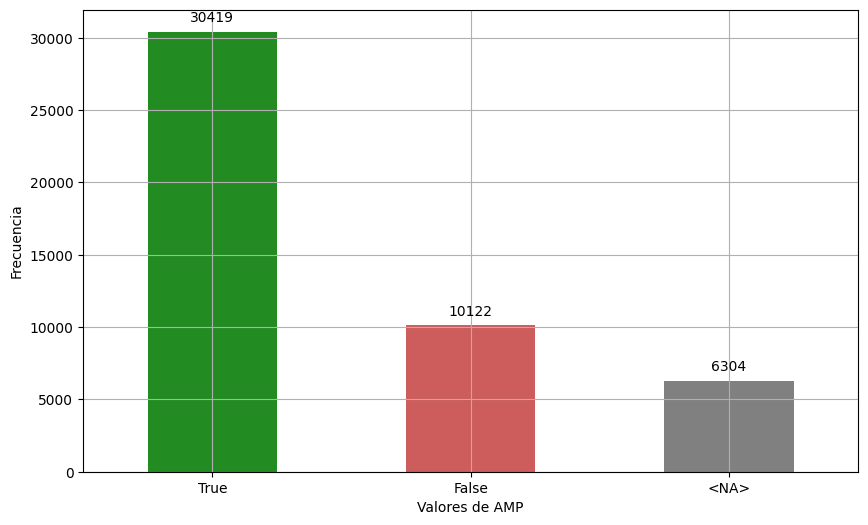

In [21]:
# Contar los valores en la columna 'AMP'
conteo_amp = df_final['AMP'].value_counts(dropna=False)

# Mapeo de colores personalizado según el valor
color_map = {True: 'forestgreen', False: 'indianred', 'NaN': 'gray'}

# Crear lista de colores basada en los valores existentes
colors = [color_map.get(x, 'gray') for x in conteo_amp.index]

# Crear un gráfico de barras
plt.figure(figsize=(10, 6))
bars = conteo_amp.plot(kind='bar', color=colors)
plt.title('')
plt.xlabel('Valores de AMP')
plt.ylabel('Frecuencia')
plt.xticks(rotation=0) 
plt.grid(True)

# Añadir valores dentro de las barras
for p in bars.patches:
    height = int(p.get_height())
    bars.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                  ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
# Guardar la figura antes de mostrarla
plt.savefig("graph_plots/num_seq_no_filt.png", bbox_inches='tight', dpi=300)

plt.show()

# Filtrado de péptidos antimicrobianos para Machine learning

Un péptido puede tener más de una actividad, y que estas pueden ser antimicrobianas o no. Si un péptido tiene una actividad antimicrobiana, ya es considerado péptido antimicrobiano, y por ello, el siguiente paso es eliminar las actividades no antimicrobianas o desconocidas para un péptido cuando ya se ha identificado como antimicrobiano.

In [22]:
# Limpieza de secuencias repetidas con diferentes valores de AMP
df_ML = df_final.copy()

# Priorizamos 'True' sobre 'False' y 'NaN' mediante el uso de una clave de ordenamiento 
orden_prioridad = {True: 0, False: 1, pd.NA: 2}
df_ML['orden'] = df_ML['AMP'].map(orden_prioridad)
df_ML.sort_values(by=['Sequence', 'orden'], inplace=True)

# Mantenemos la primera entrada de cada sequencia
df_ML.drop_duplicates(subset='Sequence', keep='first', inplace=True)

# Eliminar la columna auxiliar 'orden'
df_ML.drop(columns='orden', inplace=True)

Nos quedamos solo con los que tienen una longitud entre 7 y 150 aa's. Se ha seleccionado este rango debido a que
la base de datos UniProt no tiene secuencias menores a 7 aminoácidos.

In [23]:
# Filtrar los aminoácidos para quedarme solo con los que están entre 7 y 150. 

df_ML = df_ML[df_ML['Sequence'].apply(len).between(7, 150)]
df_ML = df_ML[~df_ML['Sequence'].str.contains(' |[a-z]', regex=True)]

df_ML.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19245 entries, 4683 to 16713
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID_Peptide  19245 non-null  object
 1   PubMed_ID   234 non-null    object
 2   UniProt_ID  4792 non-null   object
 3   APD3_ID     2941 non-null   object
 4   Sequence    19245 non-null  object
 5   Activity    19245 non-null  object
 6   db_source   19245 non-null  object
 7   Targets     14378 non-null  object
 8   Code        19245 non-null  int64 
 9   AMP         13997 non-null  object
dtypes: int64(1), object(9)
memory usage: 1.6+ MB


De esta forma, nuestra base de datos final para Machine Learning tiene **21016 filas** y **9 columnas** (ID_Peptide, PumMed_ID, UniProt_ID, APD3_ID, Sequence , Activity, Target, Code y AMP). Este archivo ya se ha filtrado para machine Learnig. Cuando un peptido tenia funcion AMP y no AMP, se ha eliminado la fila en la que aparecía con función no AMP.

Además, nos aseguraremos de que todas las secuencias cumplen las mínimas reglas para poder ser procesadas por Propythia.

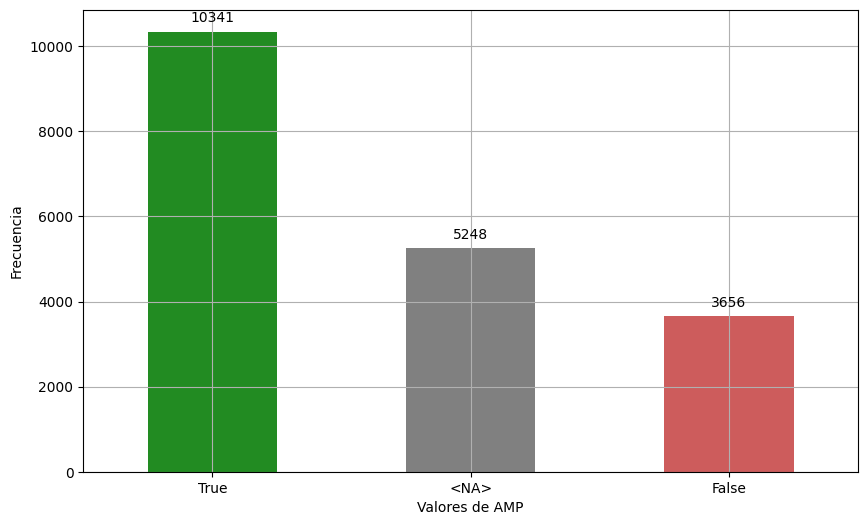

In [25]:
# Contar los valores en la columna 'AMP'
conteo_amp = df_ML['AMP'].value_counts(dropna=False)

# Mapeo de colores personalizado según el valor
color_map = {True: 'forestgreen', False: 'indianred', 'NaN': 'gray'}

# Crear lista de colores basada en los valores existentes
colors = [color_map.get(x, 'gray') for x in conteo_amp.index]

# Crear un gráfico de barras
plt.figure(figsize=(10, 6))
bars = conteo_amp.plot(kind='bar', color=colors)
plt.title('')
plt.xlabel('Valores de AMP')
plt.ylabel('Frecuencia')
plt.xticks(rotation=0)  # Rotar etiquetas si son largas o numerosas
plt.grid(True)

# Añadir valores dentro de las barras
for p in bars.patches:
    height = int(p.get_height())
    bars.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                  ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    

# Guardar la figura antes de mostrarla
plt.savefig("graph_plots/num_seq_filt_ML.png", bbox_inches='tight', dpi=300)

plt.show()

In [26]:
# Guardar el DataFrame en un archivo CSV

df_ML.to_csv('files_results/db_AMP_ML.csv', index=False)